In [55]:
import torch
from torchvision import transforms
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import os

from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'cv2'

# Converting Images to Tensor and Making train-test split

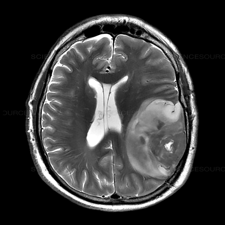

In [31]:
gray_scale = transforms.Grayscale()
image = Image.open("yes\Y108.jpg")
image = image.resize((225,225))
image = gray_scale(image)
image

In [66]:
convert_tensor = transforms.ToTensor()
gray_scale = transforms.Grayscale()
directory = 'yes'
first = True
transform = transforms.Grayscale()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((225,225))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        print(tf.shape(tensor))

tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)
tf.Tensor([225 225   1], shape=(3,), dtype=int32)


In [67]:
convert_tensor = transforms.ToTensor( )
gray_scale = transforms.Grayscale()
directory = 'no'
first = True

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((225,225))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            no_images = np.array([tensor])
            no_labels = np.array([[0]])
            first = False
        else:
            no_images = np.concatenate((no_images, np.array([tensor])))
            no_labels = np.concatenate((no_labels, np.array([[0]])))


In [68]:
convert_tensor = transforms.ToTensor()
gray_scale = transforms.Grayscale()
directory = 'yes'
first = True

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((225,225))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            yes_images = np.array([tensor])
            yes_labels = np.array([[1]])
            first = False
        else:
            yes_images = np.concatenate((yes_images, np.array([tensor])))
            yes_labels = np.concatenate((yes_labels, np.array([[1]])))

In [69]:
images = np.concatenate((no_images, yes_images))
labels = np.concatenate((no_labels, yes_labels))

In [70]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = 42)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Modeling

In [71]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(225, 225, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 223, 223, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
7/7 [==============================] - 7s 154ms/step - loss: 0.7136 - accuracy: 0.6287 - val_loss: 0.6927 - val_accuracy: 0.6078
Epoch 2/10
7/7 [==============================] - 0s 50ms/step - loss: 0.6916 - accuracy: 0.6139 - val_loss: 0.6826 - val_accuracy: 0.6078
Epoch 3/10
7/7 [==============================] - 0s 50ms/step - loss: 0.6739 - accuracy: 0.6139 - val_loss: 0.6697 - val_accuracy: 0.6078
Epoch 4/10
7/7 [==============================] - 0s 50ms/step - loss: 0.6714 - accuracy: 0.6139 - val_loss: 0.6709 - val_accuracy: 0.6078
Epoch 5/10
7/7 [==============================] - 0s 51ms/step - loss: 0.6663 - accuracy: 0.6139 - val_loss: 0.6699 - val_accuracy: 0.6078
Epoch 6/10
7/7 [==============================] - 0s 50ms/step - loss: 0.6693 - accuracy: 0.6139 - val_loss: 0.6698 - val_accuracy: 0.6078
Epoch 7/10
7/7 [==============================] - 0s 50ms/step - loss: 0.6675 - accuracy: 0.6139 - val_loss: 0.6698 - val_accuracy: 0.6078
Epoch 8/10
7/7 [==========